In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta


In [2]:

# Configurable variables
SEQUENCE_LENGTH = 36  # Number of consecutive datapoints (144 is 1 day with 10-min intervals)
SEQUENCE_STEP = 36


TEST_EVENT_IDS = [79, 46]  # Event IDs for training
TRAIN_EVENT_IDS = [30, 65]  # Event IDs for testing
TIME_STEP = timedelta(minutes=10)  # Expected time difference between consecutive rows

# File paths
ASSET_NUMBER = 16
DATA_PATH = f'./by_asset/C/assets/{ASSET_NUMBER}.csv'
EVENTS_PATH = f'./by_asset/C/assets/{ASSET_NUMBER}_events.csv'
FEATURE_DESCRIPTION_PATH = './CARE_To_Compare/Wind Farm C/feature_description.csv'


def load_data():
    """Load the sensor data, event data, and feature descriptions."""
    data = pd.read_csv(DATA_PATH, sep=';')
    events = pd.read_csv(EVENTS_PATH, sep=';')
    feature_description = pd.read_csv(FEATURE_DESCRIPTION_PATH, sep=';')
    return data, events, feature_description


def preprocess_data(data, events):
    """Preprocess the data by converting timestamps and assigning event labels."""
    # Convert time columns to datetime
    data['time_stamp'] = pd.to_datetime(data['time_stamp'])
    events['event_start'] = pd.to_datetime(events['event_start'])
    events['event_end'] = pd.to_datetime(events['event_end'])

    # Assign event labels to the data
    data['event'] = 'other'
    for _, event in events.iterrows():
        mask = (data['time_stamp'] >= event['event_start']) & (data['time_stamp'] <= event['event_end'])
        data.loc[mask, 'event'] = event['event_label']

    # Map event labels to binary classes
    data['event_class'] = data['event'].apply(lambda x: 1 if x == 'anomaly' else 0)
    return data


def create_sensor_mapping(feature_description):
    """Create a mapping of sensor names to their descriptions and units."""
    required_columns = {'sensor_name', 'description', 'unit'}
    if not required_columns.issubset(feature_description.columns):
        raise ValueError(f"The feature description file must contain the columns: {required_columns}")

    shorthand_to_longhand = {
        '_avg': 'average',
        '_max': 'maximum',
        '_min': 'minimum',
        '_std': 'std_dev'
    }

    sensor_mapping = {}
    for _, row in feature_description.iterrows():
        base_sensor = row['sensor_name']
        description = row['description']
        unit = row['unit']
        for shorthand, longhand in shorthand_to_longhand.items():
            full_sensor_name = f"{base_sensor}{shorthand}"
            full_description = f"{base_sensor}: {description} [{unit}] ({longhand})"
            sensor_mapping[full_sensor_name] = full_description
    return sensor_mapping

def create_sequences(data, sequence_length, step, n_samples=None):
    """
    Create sequences. 
    If n_samples is provided, it selects the first n/2 and last n/2 sequences (Training).
    If n_samples is None, it returns all sequences found with the given step (Testing).
    """
    sequences = []
    labels = []
    timestamps = []

    # 1. Identify gaps and groups (Standard preprocessing)
    data['time_diff'] = data['time_stamp'].diff().fillna(pd.Timedelta(seconds=0))
    # Allow small tolerance
    data['is_continuous'] = data['time_diff'] <= (TIME_STEP + pd.Timedelta(seconds=1))
    data['group'] = (~data['is_continuous']).cumsum()

    # 2. Select numeric columns
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ['event_class', 'time_diff', 'is_continuous', 'group']]

    # 3. First Pass: Collect all valid indices
    valid_indices = [] 
    
    for group_id, group_data in data.groupby('group'):
        group_len = len(group_data)
        if group_len < sequence_length:
            continue
            
        # Scan through the group
        for i in range(0, group_len - sequence_length + 1, step):
            # We store just the metadata first to save RAM
            end_time = group_data['time_stamp'].iloc[i + sequence_length - 1]
            
            # Quick label calculation
            # Optimisation: We calculate the label now to store it, 
            # but for the "head/tail" strategy, we mainly care about position.
            seq_label = group_data['event_class'].iloc[i:i + sequence_length].mean()
            
            valid_indices.append({
                'group': group_id,
                'start_index': i,
                'label': seq_label,
                'time_stamp': end_time
            })

    # 4. "Head and Tail" Sampling Logic
    final_indices = valid_indices
    
    if n_samples is not None and len(valid_indices) > n_samples:
        half_n = n_samples // 2
        print(f"  [Sampling] Taking first {half_n} and last {half_n} sequences from {len(valid_indices)} total candidates.")
        
        head = valid_indices[:half_n]
        tail = valid_indices[-half_n:]
        
        # Combine them
        final_indices = head + tail
    elif n_samples is not None:
        print(f"  [Sampling] Requested {n_samples}, but only found {len(valid_indices)}. Returning all.")

    # 5. Second Pass: Build the actual arrays
    print(f"  Building {len(final_indices)} sequences...")
    
    # Optimization: Group indices by group_id to access DataFrame chunks efficiently
    indices_by_group = {}
    for item in final_indices:
        if item['group'] not in indices_by_group:
            indices_by_group[item['group']] = []
        indices_by_group[item['group']].append(item)
        
    grouped_data = dict(list(data.groupby('group')))

    for group_id, items in indices_by_group.items():
        if group_id not in grouped_data: continue
        group_df = grouped_data[group_id].reset_index(drop=True)
        
        for item in items:
            i = item['start_index']
            # Extract the heavy feature data here
            seq_values = group_df[numeric_columns].iloc[i:i+sequence_length].values.flatten()
            sequences.append(seq_values)
            labels.append(item['label'])
            timestamps.append(item['time_stamp'])

    return np.array(sequences), np.array(labels), np.array(timestamps)

def prepare_data_with_other(data, events, event_ids, sequence_length, step, pre_event_window, n_samples=None):
    """
    Prepare data for training/testing. 
    Applies sequence creation and 'Head/Tail' sampling PER EVENT ID to ensure 
    we capture both the start (Other) and end (Event) of every requested event.
    """
    all_sequences = []
    all_labels = []
    all_timestamps = []
    
    for event_id in event_ids:
        # 1. Extract data for this specific event
        event_row = events[events['event_id'] == event_id]
        if event_row.empty: 
            continue
        row = event_row.iloc[0]
        
        start_time = row['event_start'] - pre_event_window
        end_time = row['event_end']
        
        # Get the dataframe for this specific event window
        event_data = data[(data['time_stamp'] >= start_time) & (data['time_stamp'] <= end_time)]
        event_data = event_data.sort_values(by='time_stamp').drop_duplicates(subset=['time_stamp'], keep='first')
        
        if len(event_data) < sequence_length:
            continue

        # 2. Create Sequences & Sample immediately for this event
        # If n_samples is set (Training), it takes Head/Tail of THIS event.
        # If n_samples is None (Testing), it takes all unoverlapping chunks of THIS event.
        seqs, lbls, tstamps = create_sequences(event_data, sequence_length, step, n_samples=n_samples)
        
        if len(seqs) > 0:
            all_sequences.append(seqs)
            all_labels.append(lbls)
            all_timestamps.append(tstamps)

    if not all_sequences:
        raise ValueError("No valid sequences generated for the given event IDs.")

    # 3. Concatenate all events together
    X = np.concatenate(all_sequences)
    y = np.concatenate(all_labels)
    t = np.concatenate(all_timestamps)
    
    # Return a lightweight DataFrame for visualization that matches strictly what was selected
    viz_data = pd.DataFrame({'time_stamp': t})
    
    return (X, y, t), viz_data


def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    """Train an XGBoost REGRESSOR model and evaluate its performance."""
    print("--- Model Training (XGBoost Regressor) ---")
    
    # 1. Instantiate Regressor
    model = XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=100, 
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # 2. Reshape 3D sequence data (samples, seq_len, features) to 2D (samples, seq_len * features)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # 3. Fit the model
    model.fit(X_train_flat, y_train)
    print("Model training complete.")

    # 4. Evaluate the model
    y_pred = model.predict(X_test_flat)
    
    # Calculate Regression Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Evaluation (Regression Metrics) ---")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Test R-squared (R2): {r2:.4f}")

    # Return the trained model
    return model


def plot_sensor(data, sensor_mapping):
    """Create an interactive plot for sensor data."""
    def plot(sensor_id):
        if sensor_id not in data.columns:
            raise ValueError(f"Sensor '{sensor_id}' not found in the data.")

        plt.figure(figsize=(12, 6))

        # Filter data based on event type
        anomaly = data[data['event'] == 'anomaly']
        normal = data[data['event'] == 'normal']
        other = data[data['event'] == 'other']

        # Plot data with different colors, ensuring red and green are on top
        plt.plot(other['time_stamp'], other[sensor_id], 'b.', label='Other', alpha=0.5)
        plt.plot(normal['time_stamp'], normal[sensor_id], 'g.', label='Normal', alpha=0.8)
        plt.plot(anomaly['time_stamp'], anomaly[sensor_id], 'r.', label='Anomaly', alpha=0.8)

        plt.title(f'Plot of {sensor_mapping[sensor_id]}')
        plt.xlabel('Time Stamp')
        plt.ylabel(sensor_mapping[sensor_id])
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()
        plt.show()

    # Create a dropdown for sensor selection
    sensor_columns = [col for col in data.columns if col.startswith('sensor_') or col.startswith('power_') or col.startswith('wind_speed_')]
    sensor_options = {sensor_mapping[sensor]: sensor for sensor in sensor_columns if sensor in sensor_mapping}

    if not sensor_options:
        raise ValueError("No matching sensors found between the data and the feature description file.")

    interact(plot, sensor_id=Dropdown(options=sensor_options, description='Select Sensor:'))


data, events, feature_description = load_data()
data = preprocess_data(data, events)





/var/folders/75/ql8v_2rx6v31k_cvbx9k4t500000gn/T/ipykernel_80965/3495369659.py:19: DtypeWarning: Columns (963) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH, sep=';')


In [3]:
sensor_mapping = create_sensor_mapping(feature_description)

# Plot sensor data
plot_sensor(data, sensor_mapping)


interactive(children=(Dropdown(description='Select Sensor:', options={'sensor_0: ABB-LS Input K1, IL1 [A] (ave…

Preparing TRAINING data (Head/Tail per Event)...
  [Sampling] Taking first 50 and last 50 sequences from 4634 total candidates.
  Building 100 sequences...
  [Sampling] Taking first 50 and last 50 sequences from 6342 total candidates.
  Building 100 sequences...
Train shapes: X=(200, 34488), y=(200,)

Preparing TESTING data (Unoverlapping)...
  Building 212 sequences...
  Building 178 sequences...
Test shapes: X=(390, 34488), y=(390,)


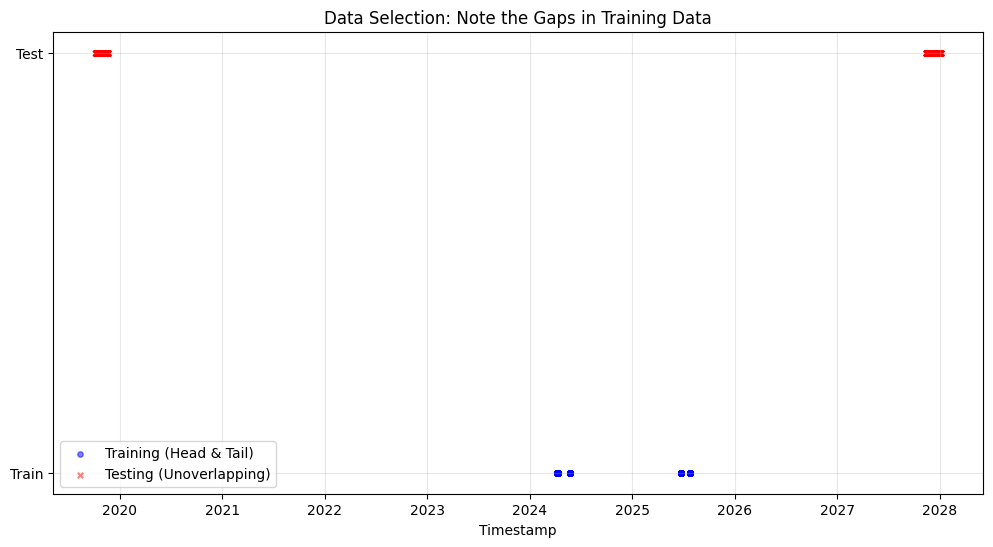

--- Model Training (XGBoost Regressor) ---
Model training complete.

--- Model Evaluation (Regression Metrics) ---
Test Root Mean Squared Error (RMSE): 0.2032
Test Mean Absolute Error (MAE): 0.0419
Test R-squared (R2): 0.7672


/Users/osma/ARotor/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


interactive(children=(Dropdown(description='Select Event ID:', options=(30, 65), value=30), Output()), _dom_cl…

In [4]:
# --- CONFIGURATION ---
PRE_EVENT_WINDOW = timedelta(hours=int(365/12*24)) # 1 Month Lookback
N_TRAIN_SAMPLES = 100  # Samples PER EVENT (50 from start, 50 from end)

# --- EXECUTION ---

print("Preparing TRAINING data (Head/Tail per Event)...")
# Training: Step=1 for dense scanning, then keep First N/2 and Last N/2 of EACH event
(train_sequences, train_labels, train_timestamps), train_data_viz = prepare_data_with_other(
    data, events, TRAIN_EVENT_IDS, SEQUENCE_LENGTH, step=1, 
    pre_event_window=PRE_EVENT_WINDOW, n_samples=N_TRAIN_SAMPLES
)
print(f"Train shapes: X={train_sequences.shape}, y={train_labels.shape}")


print("\nPreparing TESTING data (Unoverlapping)...")
# Testing: Unoverlapping (step=SEQUENCE_LENGTH), Keep ALL (n_samples=None)
(test_sequences, test_labels, test_timestamps), test_data_viz = prepare_data_with_other(
    data, events, TEST_EVENT_IDS, SEQUENCE_LENGTH, step=SEQUENCE_LENGTH, 
    pre_event_window=PRE_EVENT_WINDOW, n_samples=None
)
print(f"Test shapes: X={test_sequences.shape}, y={test_labels.shape}")

# --- VISUALIZATION ---
# This plot will now show the "Gap" you requested in the middle of the training windows
def plot_data_coverage(train_timestamps, test_timestamps):
    plt.figure(figsize=(12, 6))
    plt.scatter(train_timestamps, [0] * len(train_timestamps), color='blue', alpha=0.5, s=15, label='Training (Head & Tail)')
    plt.scatter(test_timestamps, [1] * len(test_timestamps), color='red', alpha=0.5, s=15, marker='x', label='Testing (Unoverlapping)')
    plt.yticks([0, 1], ['Train', 'Test'])
    plt.title("Data Selection: Note the Gaps in Training Data")
    plt.xlabel("Timestamp")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_data_coverage(train_timestamps, test_timestamps)

# Train the model
model = train_and_evaluate_model(train_sequences, train_labels, test_sequences, test_labels)

def compare_labels(event_id):
    event = events[events['event_id'] == event_id]
    if event.empty: return

    # Extract data
    event_data_list = []
    for _, row in event.iterrows():
        start_time = row['event_start'] - PRE_EVENT_WINDOW
        end_time = row['event_end']
        event_data_list.append(data[(data['time_stamp'] >= start_time) & (data['time_stamp'] <= end_time)])
    
    event_data = pd.concat(event_data_list).sort_values(by='time_stamp').drop_duplicates(subset=['time_stamp'], keep='first').reset_index(drop=True)

    # USE UNOVERLAPPING STEP for plotting comparison
    eval_step = SEQUENCE_LENGTH 
    
    # n_samples=None to keep all unoverlapping segments
    X_event, y_event, event_timestamps = create_sequences(event_data, SEQUENCE_LENGTH, step=eval_step, n_samples=None)
    
    if len(X_event) == 0: return

    # Predict
    X_event_flat = X_event.reshape(X_event.shape[0], -1)
    y_pred_event = model.predict(X_event_flat)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(event_timestamps, y_event, label='True', color='blue', marker='o')
    plt.plot(event_timestamps, y_pred_event, label='Predicted', color='red', linestyle='--')
    plt.title(f"Event {event_id} (Unoverlapping 5-day windows)")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid()
    plt.show()


# Create an interactive dropdown to select an event ID for comparison
def interactive_comparison():
    event_ids = TEST_EVENT_IDS  # Use test event IDs for comparison
    interact(compare_labels, event_id=Dropdown(options=event_ids, description='Select Event ID:'))

# Call the interactive comparison function
interactive_comparison()